# Generating a random population for West London

This notebook demonstrates an complex example workflow for creating a sample population for an area in West London. It creates agent plans for people and households using a random process.

## Aim
Create a bigger and more realistic sample population automatically for the West London area called Londinium. 
The sample population includes various activities, personal attributes and modes; the population would be used as input for MATSim transport simulation.

Steps:

1. [Import geographic data of Londinium;](#import-geographic-data-of-londinium)
2. [Facility sampling from OpenStreetMap data;](#facility-sampler)
2. [Activity generation model with home based tours. Expand agents with different personal attributes, activities and trips;](#activity-generation-model)
3. [Perform Data Visualization and validation. Plot the activity plan, distance and duration of population;](#data-visulazation-and-validation)
4. [Export intermediate CSV tables of the population](#readwrite-data)

In [46]:
import os

import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pam.activity import Activity, Leg
from pam.core import Household, Person, Population
from pam.plot.stats import plot_activity_times
from pam.read import load_travel_diary, read_matsim
from pam.report.benchmarks import distance_counts, duration_counts
from pam.samplers import facility
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from pam.write import to_csv, write_matsim, write_od_matrices

%matplotlib inline

## Import geographic data of Londinium

In [47]:
# Import geographic data of west london area
network_bb_path = os.path.join("data", "network_bounding_box.geojson")
lsoas_path = os.path.join("data", "lsoas")  # lsoas: lower layer super output areas

We will start by plotting Londinium boundary

<Axes: >

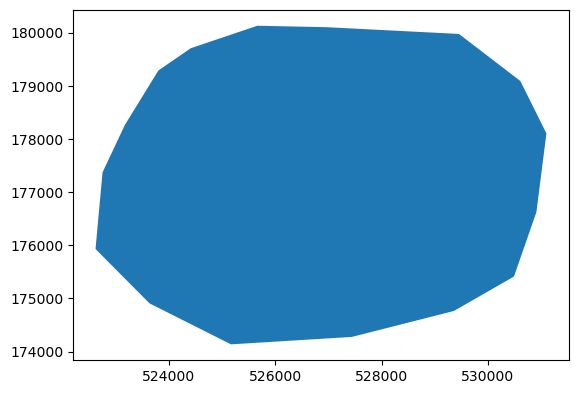

In [48]:
# Read the file and plot the boundary
boundary = gp.read_file(network_bb_path)

# Transform to epsg:27700
boundary = boundary.to_crs("epsg:27700")
boundary.plot()

Next we will plot Londinium outline shown above over a map of London to see where exactly it is located.

EPSG:27700


<Axes: >

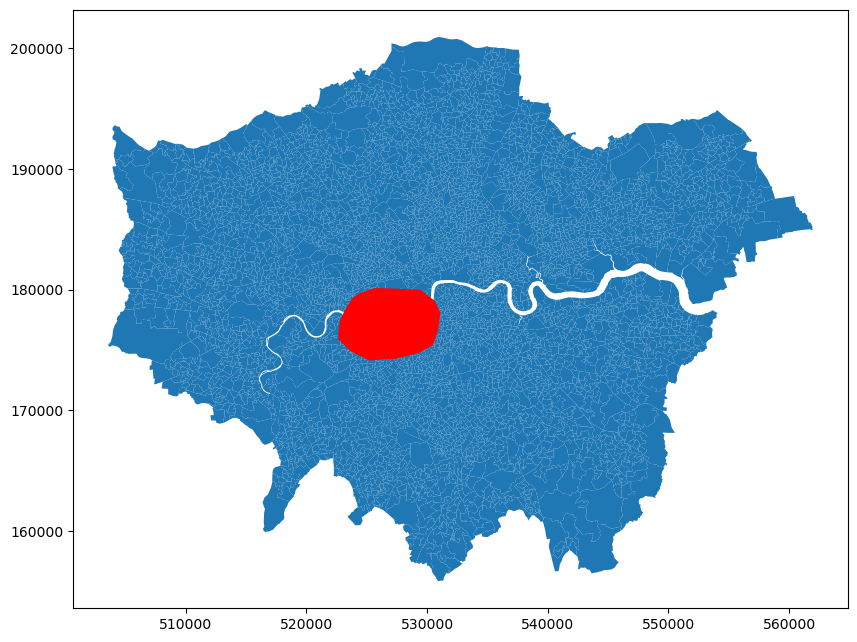

In [49]:
# Plot boundary area in lsoas
lsoas = gp.read_file(lsoas_path)
lsoas.crs = "EPSG:27700"
print(lsoas.crs)
lsoas = lsoas.set_index("LSOA_CODE")

fig, ax = plt.subplots(figsize=(10, 10))
lsoas.plot(ax=ax)
boundary.plot(ax=ax, color="red")

Finally, we will plot Londinium with LSOA boundaries included.

/Users/bryn.pickering/mambaforge/envs/pam/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


<Axes: >

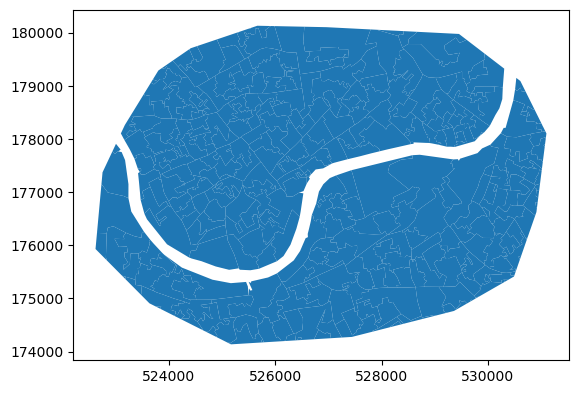

In [50]:
# Overlay the area using geopandas package
lsoas_clipped = gp.overlay(lsoas, boundary, how="intersection")
lsoas_clipped.plot()

In [51]:
lsoas_clipped.head()

,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry
0,Hammersmith and Fulham 010A,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((523916.969 179317.120, 523953.998 17..."
1,Hammersmith and Fulham 010B,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((524171.272 179363.077, 524212.654 17..."
2,Hammersmith and Fulham 010C,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((523785.361 179088.406, 523717.315 17..."
3,Hammersmith and Fulham 012A,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"POLYGON ((524167.660 178997.302, 524060.845 17..."
4,Hammersmith and Fulham 012B,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"POLYGON ((523774.000 178714.003, 523831.847 17..."


## Facility sampler

In [52]:
facilities_path = "data/londinium_facilities_sample.geojson"
facilities = gp.read_file(facilities_path)
facilities = facilities.rename({"activities": "activity"}, axis=1)
facilities.crs = "EPSG:27700"
facilities.head()

,activity,area,distance_to_nearest_education,distance_to_nearest_medical,distance_to_nearest_shop,distance_to_nearest_transit,floor_area,id,levels,units,geometry
0,home,574,617.965594,516.743962,77.712882,466.059745,1148.0,1084822608,2.0,1.0,POINT (524877.659 179721.080)
1,home,66,143.055807,115.674294,125.537224,286.017738,198.0,368319574,3.0,1.0,POINT (527830.357 174758.729)
2,home,103,54.946075,214.532285,41.572871,93.975944,412.0,1640220880,4.0,1.0,POINT (526060.994 178970.515)
3,home,192,164.455318,216.217139,111.674214,180.452314,768.0,1741392588,4.0,1.0,POINT (526698.625 178513.841)
4,home,123,173.648285,249.190465,188.276309,139.258340,246.0,984446626,2.0,1.0,POINT (526369.238 179166.396)


Start by plotting different facility types, e.g. educational and medical facilities

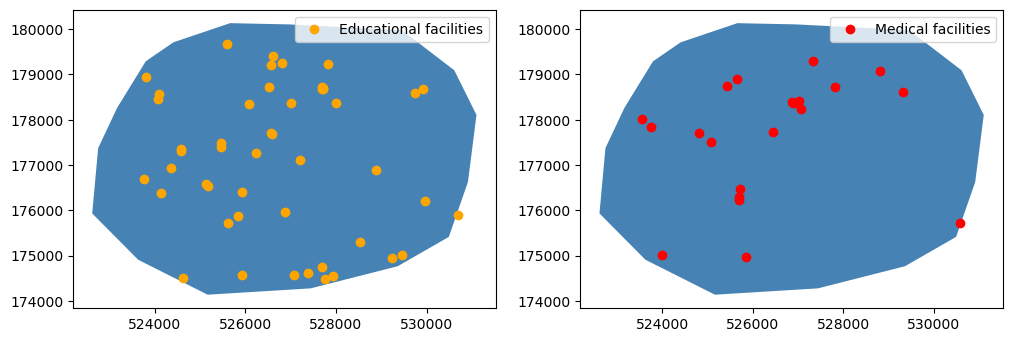

In [53]:
education = facilities[facilities["activity"] == "education"]
medical = facilities[facilities["activity"] == "medical"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

boundary.plot(ax=ax1, color="steelblue")
education.plot(ax=ax1, color="orange", label="Educational facilities")
ax1.legend()

boundary.plot(ax=ax2, color="steelblue")
medical.plot(ax=ax2, color="red", label="Medical facilities")
ax2.legend()

In [54]:
lsoas_clipped.crs = "EPSG:27700"
len(lsoas_clipped)

304

In [55]:
lsoas_clipped = lsoas_clipped.set_index("LSOA_NAME")

In [56]:
# build the sampler
facility_sampler = facility.FacilitySampler(
    facilities=facilities, zones=lsoas_clipped, build_xml=True, fail=False, random_default=True
)

Joining facilities data to zones, this may take a while.
Building sampler, this may take a while.


## Activity generation model

In [57]:
# Create random area sample


def random_area_sampler():
    indexes = list(lsoas_clipped.index)
    return np.random.choice(indexes)


random_area_sampler()  # test

'Hammersmith and Fulham 024B'

- It is a simple home based tours within 24 hours. 
- We create different activity types: work, leisure, education, shopping, etc. Different transport model types: car, bus, subway, etc. 
- Random number is assigned to the duration for each activity and transport mode

In [58]:
# mapping the MSOA and LAD with index
mapping_dict = dict(zip(lsoas_clipped.index, lsoas_clipped.MSOA_CODE))
mapping_dict1 = dict(zip(lsoas_clipped.index, lsoas_clipped.LA_NAME))

In [59]:
# Generate agents in west london area


def generate_agents(no_of_agents):
    """
    Randomly create agents with simple home-based tours.
    The trip starts from home, has a random number of various acitivites, tranport modes would be added.
    The trip finally ends at home.

    """
    population = Population()  # Initialise an empty population

    # Create simple personal attributes
    income = ["low", "medium", "high"]
    gender = ["male", "female"]
    sort_age = [
        "0 to 4",
        "5 to 10",
        "11 to 15",
        "16 to 20",
        "21 to 25",
        "26 to 29",
        "30 to 39",
        "40 to 49",
        "50 to 59",
        "60 to 64",
        "65 to 69",
        "70 to 74",
        "75 to 79",
        "80 to 84",
        "85  and over",
    ]

    # Create mode and activities
    transport = ["car", "bus", "ferry", "rail", "subway", "bike", "walk"]
    # Removed gym and park due to osmox problem
    activity = [
        "leisure",
        "work",
        "shop",
        "medical",
        "education",
        "park",
        "pub",
        "gym",
    ]  # Primary activity
    sub_activity = [
        "shop",
        "medical",
        "pub",
        "gym",
    ]  # People usually spend less time on sub activity

    # Add activity plan for each person
    for i in range(no_of_agents):
        # Create different agents and household
        agent_id = f"agent_{i}"
        hh_id = f"hh_{i}"
        hh = Household(hh_id, freq=1)

        # Adding Activities and Legs alternately to different agents
        # Activity 1 - home
        leaves_home = (np.random.randint(6, 8) * 60) + np.random.randint(0, 100)  # minutes
        location1 = random_area_sampler()
        location1_loc = facility_sampler.sample(location1, "home")
        lsoa_name = mapping_dict.get(location1)
        lad_name = mapping_dict1.get(location1)

        agent = Person(
            agent_id,
            freq=1,
            attributes={
                "subpopulation": np.random.choice(income) + " income",
                "gender": np.random.choice(gender),
                "age": np.random.choice(sort_age),
                "household_zone": location1,
                "household_LSOA": lsoa_name,
                "household_LAD": lad_name,
            },
        )

        hh.add(agent)
        population.add(hh)

        # Trip duration
        trip_duration_main_activity = np.random.randint(3, 6) * 60
        trip_duration_sub_activity = np.random.randint(1, 3) * 60

        agent.add(
            Activity(
                seq=1,
                act="home",
                area=location1,
                loc=location1_loc,
                start_time=mtdt(0),
                end_time=mtdt(leaves_home),
            )
        )

        # Initiated parameters
        location_prev = location1
        location_prev_loc = location1_loc
        leave_time = leaves_home

        # Add random numbers of activities
        no_of_activities = np.random.randint(1, 5)

        for i in range(no_of_activities):
            arrives_primary = leave_time + np.random.randint(10, 90)  # minutes

            # Activity 2.
            if i < 2:  # Start with main activity
                random_act = np.random.choice(activity)
            else:
                random_act = np.random.choice(sub_activity)

            if random_act == ("work"):
                leaves_primary = arrives_primary + trip_duration_main_activity
            else:
                leaves_primary = arrives_primary + trip_duration_sub_activity

            # Outbound leg
            location_next = random_area_sampler()
            location_next_loc = facility_sampler.sample(location_next, random_act)

            agent.add(
                Leg(
                    seq=i + 1,
                    mode=np.random.choice(transport),
                    start_area=location_prev,
                    start_loc=location_prev_loc,
                    end_area=location_next,
                    end_loc=location_next_loc,
                    start_time=mtdt(leave_time),
                    end_time=mtdt(arrives_primary),
                )
            )

            agent.add(
                Activity(
                    seq=i + 2,
                    act=random_act,
                    area=location_next,
                    loc=location_next_loc,
                    start_time=mtdt(arrives_primary),
                    end_time=mtdt(leaves_primary),
                )
            )

            # Update parameters
            leave_time = leaves_primary
            location_prev = location_next
            location_prev_loc = location_next_loc

        # Inbound leg
        arrives_home = leave_time + np.random.randint(10, 90)  # minutes
        agent.add(
            Leg(
                seq=no_of_activities + 1,
                mode=np.random.choice(transport),
                start_area=location_next,
                start_loc=location_next_loc,
                end_area=location1,
                end_loc=location1_loc,
                start_time=mtdt(leave_time),
                end_time=mtdt(arrives_home),
            )
        )

        # Activity
        agent.add(
            Activity(
                seq=no_of_activities + 2,
                act="home",
                area=location1,
                loc=location1_loc,
                start_time=mtdt(arrives_home),
                end_time=END_OF_DAY,
            )
        )

    return population

In [60]:
# Create 100 agents and check the population statistics
population = generate_agents(20)
print(population.stats)

Using random sample for zone:Lambeth 008D:shop
Using random sample for zone:Westminster 023B:park
Using random sample for zone:Wandsworth 003B:park
Using random sample for zone:Kensington and Chelsea 018E:gym
Using random sample for zone:Kensington and Chelsea 016B:medical
Using random sample for zone:Kensington and Chelsea 010B:medical
Using random sample for zone:Lambeth 017A:home
Using random sample for zone:Hammersmith and Fulham 012B:leisure
Using random sample for zone:Kensington and Chelsea 015A:leisure
Using random sample for zone:Hammersmith and Fulham 023C:shop
Using random sample for zone:Wandsworth 006C:leisure
Using random sample for zone:Hammersmith and Fulham 017C:pub
Using random sample for zone:Lambeth 019E:shop
Using random sample for zone:Lambeth 008B:pub
Using random sample for zone:Kensington and Chelsea 015B:pub
Using random sample for zone:Westminster 020D:park
Using random sample for zone:Wandsworth 017E:leisure
Using random sample for zone:Wandsworth 006C:leisu

{'num_households': 20, 'num_people': 20, 'num_activities': 91, 'num_legs': 71}


In [61]:
population.random_person().print()

Person: agent_11
{'subpopulation': 'high income', 'gender': 'male', 'age': '65 to 69', 'household_zone': 'Westminster 021A', 'household_LSOA': 'E02000980', 'household_LAD': 'Westminster'}
0:	Activity(act:home, location:POINT (529409.7285179333 178450.25215610824), time:00:00:00 --> 07:13:00, duration:7:13:00)
1:	Leg(mode:walk, area:POINT (529409.7285179333 178450.25215610824) --> POINT (527670.1882956816 178961.61002029953), time:07:13:00 --> 07:27:00, duration:0:14:00)
2:	Activity(act:pub, location:POINT (527670.1882956816 178961.61002029953), time:07:27:00 --> 08:27:00, duration:1:00:00)
3:	Leg(mode:subway, area:POINT (527670.1882956816 178961.61002029953) --> POINT (530726.09568668 176144.35614419598), time:08:27:00 --> 08:53:00, duration:0:26:00)
4:	Activity(act:shop, location:POINT (530726.09568668 176144.35614419598), time:08:53:00 --> 09:53:00, duration:1:00:00)
5:	Leg(mode:car, area:POINT (530726.09568668 176144.35614419598) --> POINT (529085.2787611772 178259.01048653873), tim

In [62]:
population.random_person().attributes

{'subpopulation': 'low income',
 'gender': 'female',
 'age': '80 to 84',
 'household_zone': 'Wandsworth 015E',
 'household_LSOA': 'E02000937',
 'household_LAD': 'Wandsworth'}

## Data Visulazation and validation

In [63]:
# Validation if it works
population.validate()

In [64]:
# Print random person activity plan
population.random_person().print()

Person: agent_8
{'subpopulation': 'high income', 'gender': 'male', 'age': '70 to 74', 'household_zone': 'Hammersmith and Fulham 010B', 'household_LSOA': 'E02000381', 'household_LAD': 'Hammersmith and Fulham'}
0:	Activity(act:home, location:POINT (524041.9507928425 179306.95947121904), time:00:00:00 --> 06:21:00, duration:6:21:00)
1:	Leg(mode:walk, area:POINT (524041.9507928425 179306.95947121904) --> POINT (528143.4572430026 174729.0749240057), time:06:21:00 --> 07:43:00, duration:1:22:00)
2:	Activity(act:leisure, location:POINT (528143.4572430026 174729.0749240057), time:07:43:00 --> 09:43:00, duration:2:00:00)
3:	Leg(mode:car, area:POINT (528143.4572430026 174729.0749240057) --> POINT (523777.8187493281 175845.77002682787), time:09:43:00 --> 10:12:00, duration:0:29:00)
4:	Activity(act:leisure, location:POINT (523777.8187493281 175845.77002682787), time:10:12:00 --> 12:12:00, duration:2:00:00)
5:	Leg(mode:walk, area:POINT (523777.8187493281 175845.77002682787) --> POINT (528663.360049

Plot the activities as a 24-hour diary schedules for 5 randomly chosen agents

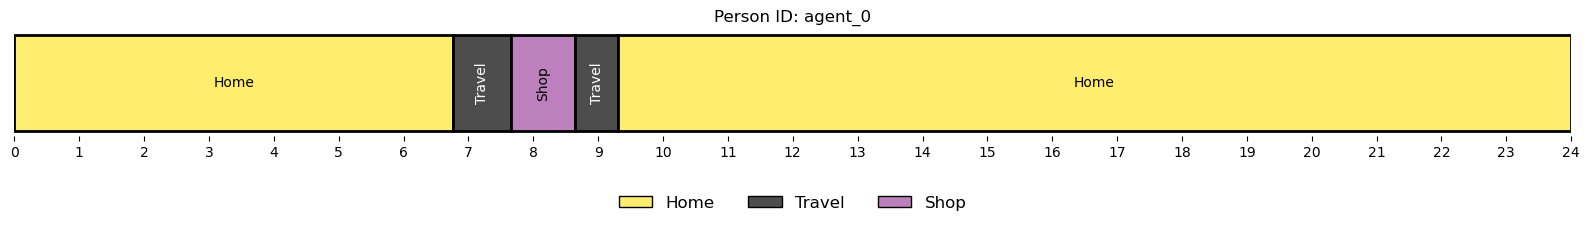

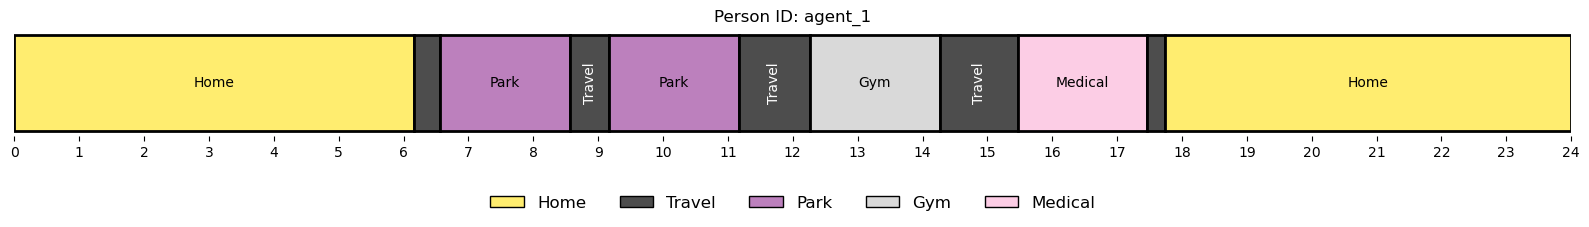

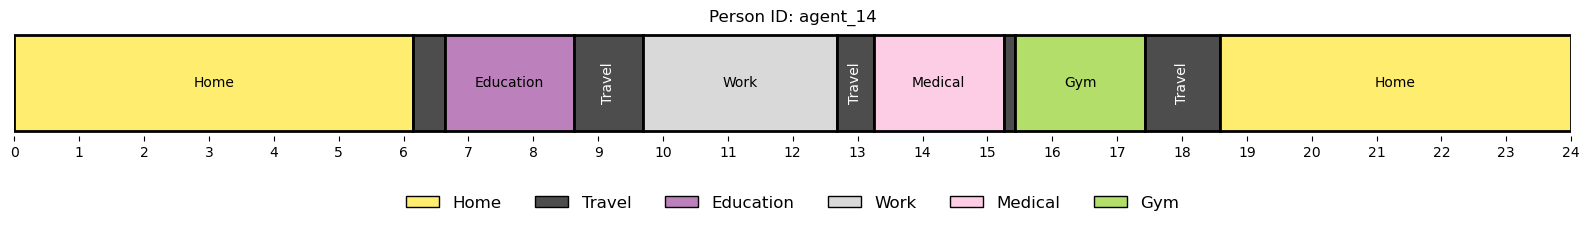

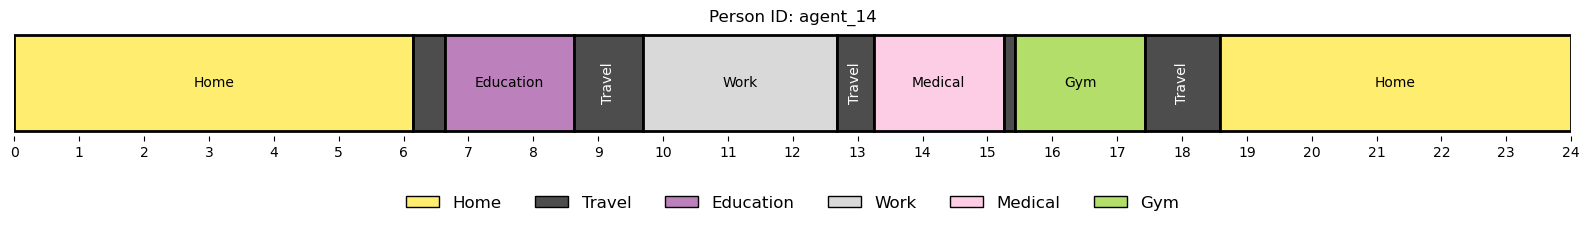

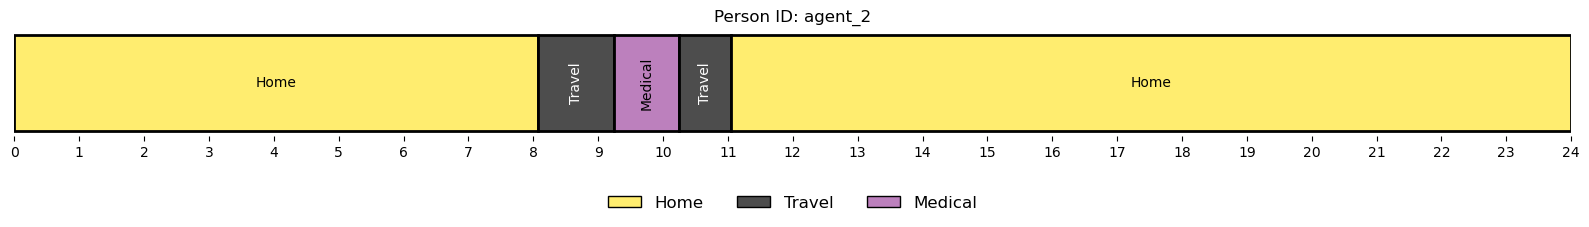

In [65]:
for _i in range(5):
    p = population.random_person()
    p.plot()

Plot the frequency with which each of the activity types happens throughout the 24-hour period.

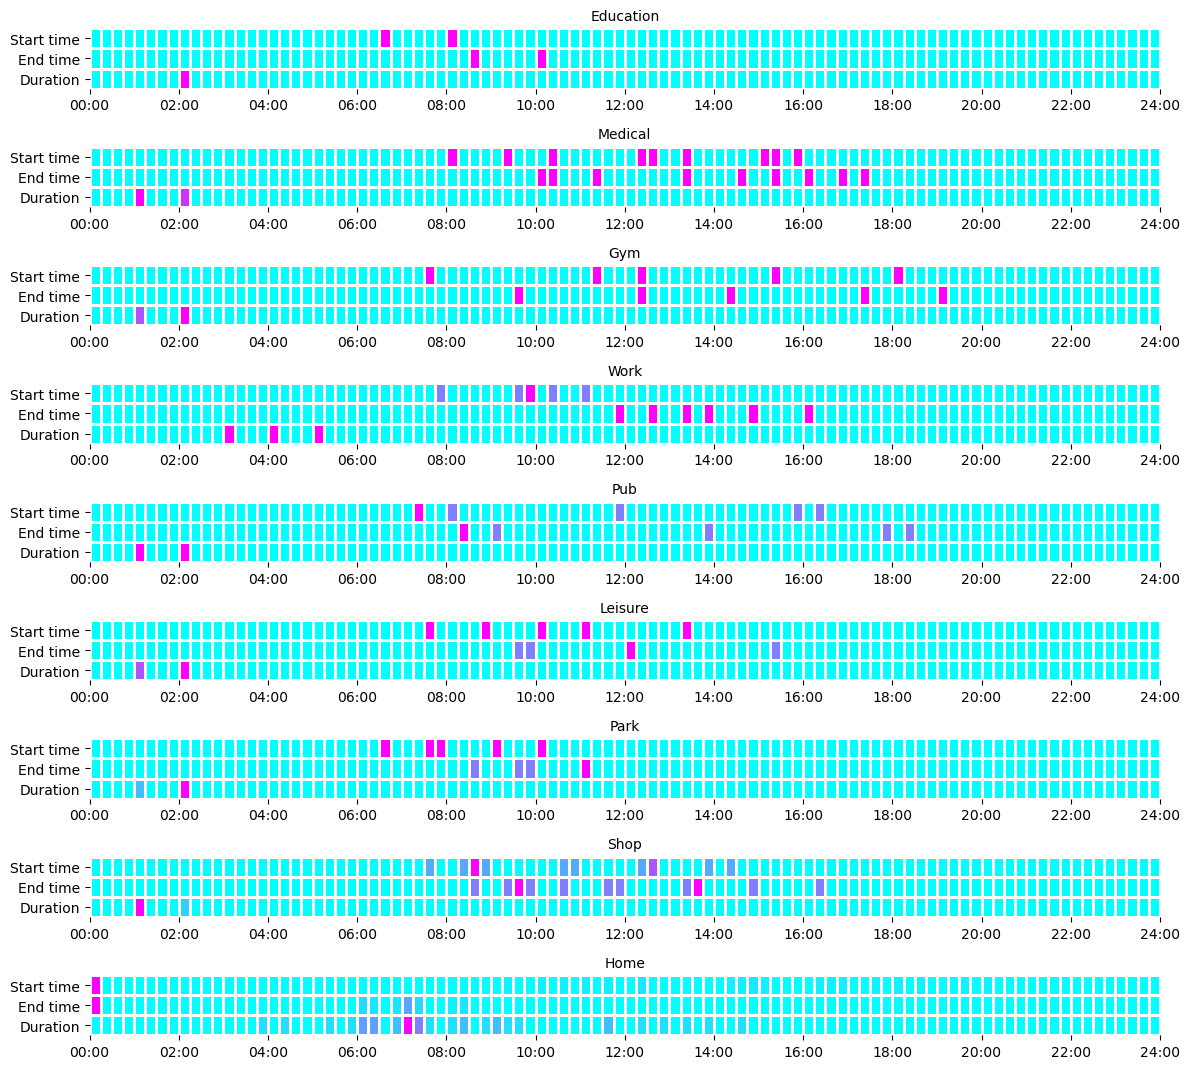

In [66]:
fig = plot_activity_times(population)

In [67]:
# Check the duration of trips
durations = duration_counts(population)
durations

,duration,trips
0,0 to 5 min,0
1,5 to 10 min,0
2,10 to 15 min,4
3,15 to 30 min,12
4,30 to 45 min,8
5,45 to 60 min,14
6,60 to 90 min,33
7,90 to 120 min,0
8,120+ min,0


Now plot a histogram for duration of the trips.

(-0.8400000000000001, 7.0)

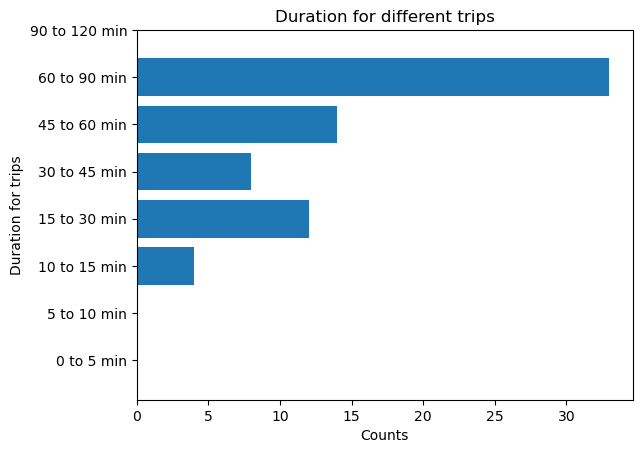

In [68]:
plt.barh(durations["duration"], durations["trips"])
plt.xlabel("Counts")
plt.ylabel("Duration for trips")
plt.title("Duration for different trips")
plt.ylim(ymax="90 to 120 min")

In [69]:
# Check the distance of trips
distances = distance_counts(population)
distances

,distance,trips
0,0 to 1 km,1
1,1 to 5 km,49
2,5 to 10 km,21
3,10 to 25 km,0
4,25 to 50 km,0
5,50 to 100 km,0
6,100 to 200 km,0
7,200+ km,0


Next we plot the distribution of trip distances.

(-0.79, 4.0)

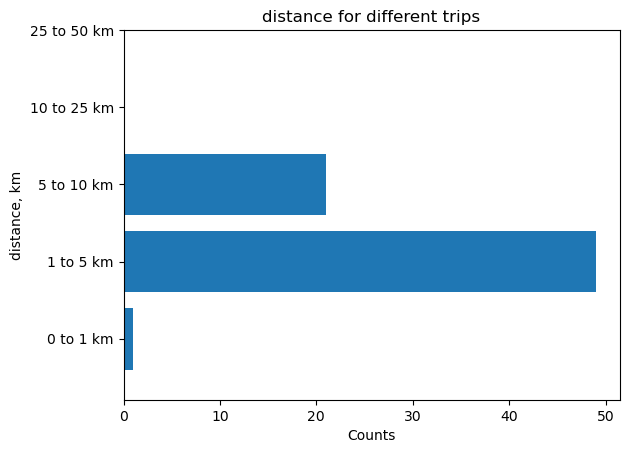

In [70]:
plt.barh(distances["distance"], distances["trips"])
plt.xlabel("Counts")
plt.ylabel("distance, km")
plt.title("distance for different trips")
plt.ylim(ymax="25 to 50 km")

## Read/write data

### Export intermediate CSV tables of population

In [71]:
to_csv(population, dir="outputs", crs="epsg:27700")

Plot the distribution of activities by type

Text(0.5, 1.0, 'activities count')

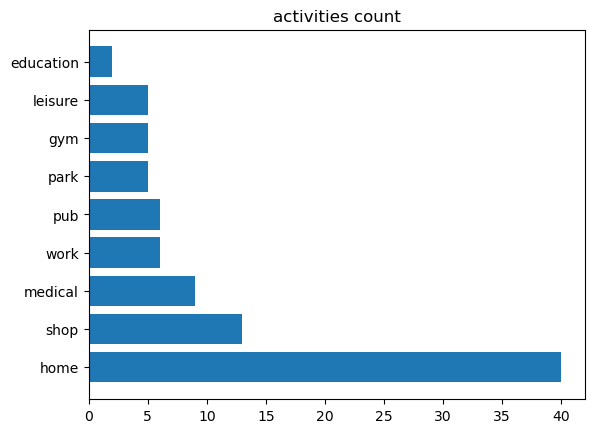

In [72]:
df_activity = pd.read_csv(os.path.join("outputs", "activities.csv"))
totals = df_activity.activity.value_counts()
plt.barh(totals.index, totals)
plt.title("activities count")

In [73]:
write_od_matrices(population, path="outputs")
od_matrices = pd.read_csv(
    os.path.join("outputs", "total_od.csv")
)  # we should change this method to be consistent with other - ie return a dataframe
od_matrices["total origins"] = od_matrices.drop("Origin", axis=1).sum(axis=1)
od_matrices

,Origin,Hammersmith and Fulham 010B,Hammersmith and Fulham 010C,Hammersmith and Fulham 010E,Hammersmith and Fulham 012B,Hammersmith and Fulham 012D,Hammersmith and Fulham 013C,Hammersmith and Fulham 016D,Hammersmith and Fulham 017C,Hammersmith and Fulham 017E,...,Westminster 019A,Westminster 019F,Westminster 020D,Westminster 021A,Westminster 022E,Westminster 023B,Westminster 023E,Westminster 024C,Westminster 024E,total origins
0,Hammersmith and Fulham 010B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,Hammersmith and Fulham 010C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Hammersmith and Fulham 010E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,Hammersmith and Fulham 012B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Hammersmith and Fulham 012D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Westminster 022E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
63,Westminster 023B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
64,Westminster 023E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
65,Westminster 024C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Plot the number of trips originating from each LSOA

Text(0.5, 1.0, 'Total Origins')

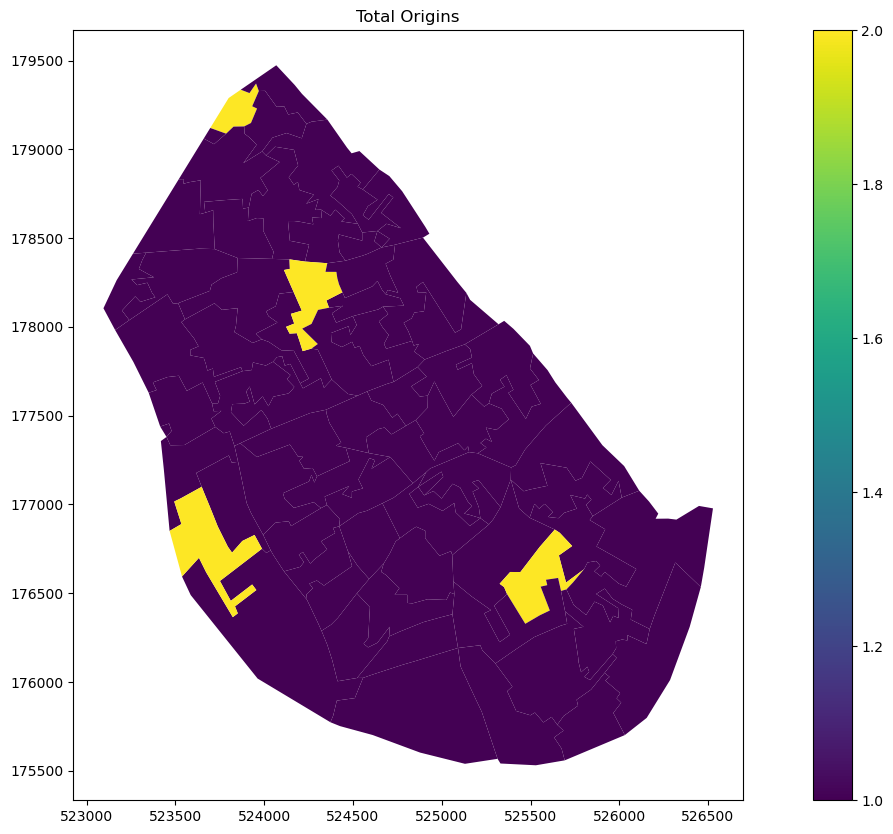

In [74]:
lsoas_clipped = lsoas_clipped.reset_index()
origins_heat_map = lsoas_clipped.join(od_matrices["total origins"])

fig, ax = plt.subplots(figsize=(18, 10))
origins_heat_map.plot("total origins", legend=True, ax=ax)
ax.set_title("Total Origins")

### Reload Tabular Data

We load in the csv files we previously wrote to disk. This replicates a simple synthesis process we might typically use for travel diary survey data.

In [75]:
people = pd.read_csv(os.path.join("outputs", "people.csv")).set_index("pid")
hhs = pd.read_csv(os.path.join("outputs", "households.csv")).set_index("hid")
trips = pd.read_csv(os.path.join("outputs", "legs.csv")).drop(["Unnamed: 0"], axis=1)

trips = trips.rename(columns={"origin activity": "oact", "destination activity": "dact"})
trips.head()

,pid,hid,freq,ozone,dzone,purp,oact,dact,mode,seq,tst,tet,duration
0,agent_0,hh_0,NaN,Wandsworth 005C,Lambeth 008D,NaN,home,shop,rail,1,1900-01-01 06:46:00,1900-01-01 07:39:00,0:53:00
1,agent_0,hh_0,NaN,Lambeth 008D,Wandsworth 005C,NaN,shop,home,walk,2,1900-01-01 08:39:00,1900-01-01 09:18:00,0:39:00
2,agent_1,hh_1,NaN,Lambeth 010D,Westminster 023B,NaN,home,park,ferry,1,1900-01-01 06:10:00,1900-01-01 06:34:00,0:24:00
3,agent_1,hh_1,NaN,Westminster 023B,Wandsworth 003B,NaN,park,park,walk,2,1900-01-01 08:34:00,1900-01-01 09:10:00,0:36:00
4,agent_1,hh_1,NaN,Wandsworth 003B,Kensington and Chelsea 018E,NaN,park,gym,subway,3,1900-01-01 11:10:00,1900-01-01 12:16:00,1:06:00


In [76]:
population_reloaded = load_travel_diary(trips=trips, persons_attributes=people, hhs_attributes=hhs)

Using from-to activity parser using 'oact' and 'dact' columns


hello there


Plot the activities as a 24-hour diary schedules

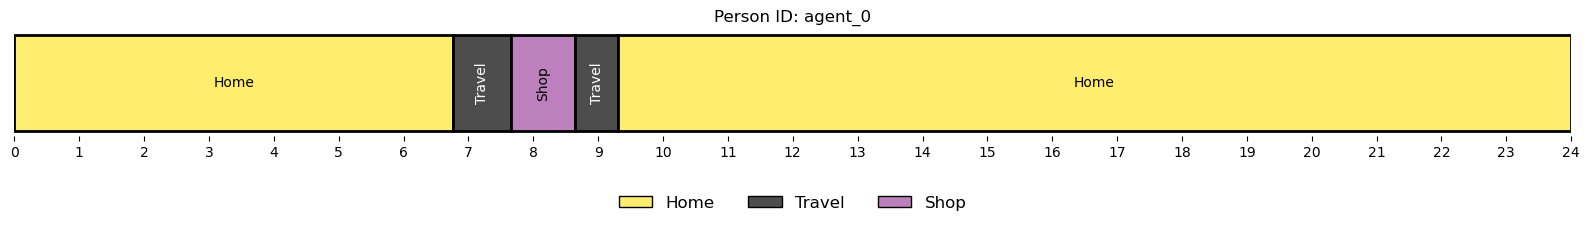

In [77]:
population["hh_0"]["agent_0"].plot()

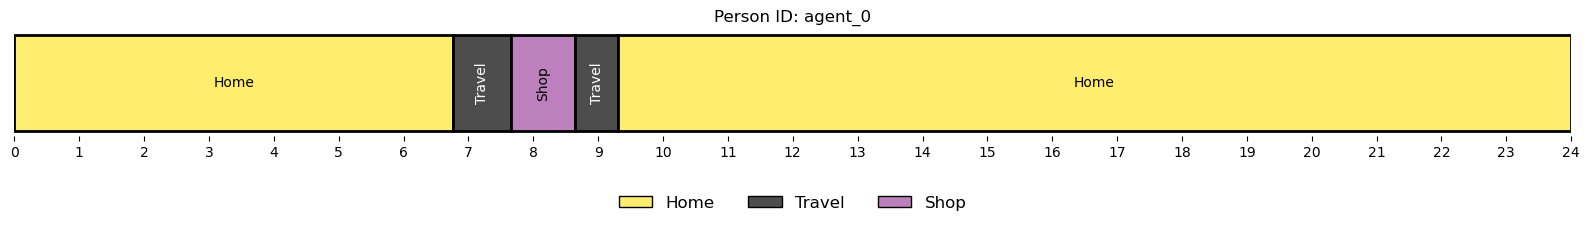

In [78]:
population_reloaded["hh_0"]["agent_0"].plot()

In [79]:
population == population_reloaded

False

The populations are not the same because the csv files did not preserve the coordinates that we previously sampled, so we will sample them again. But the reloaded population will be different as for each location a new coordinate is sampled.

### Write output to MATSim xml

In [80]:
write_matsim(population=population, plans_path=os.path.join("outputs", "population.xml"))

In [81]:
population_reloaded = read_matsim(
    plans_path=os.path.join("outputs", "population.xml"), household_key="hid", version=12
)